In [1]:
!pip install harmonica numpy matplotlib scipy seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 95.1 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


Geological model created.
Calculating gravity anomaly...
Gravity calculation complete. Anomaly range: -727.59 to 336.65 mGal
Radiometric calculation complete (with noise and smoothing).


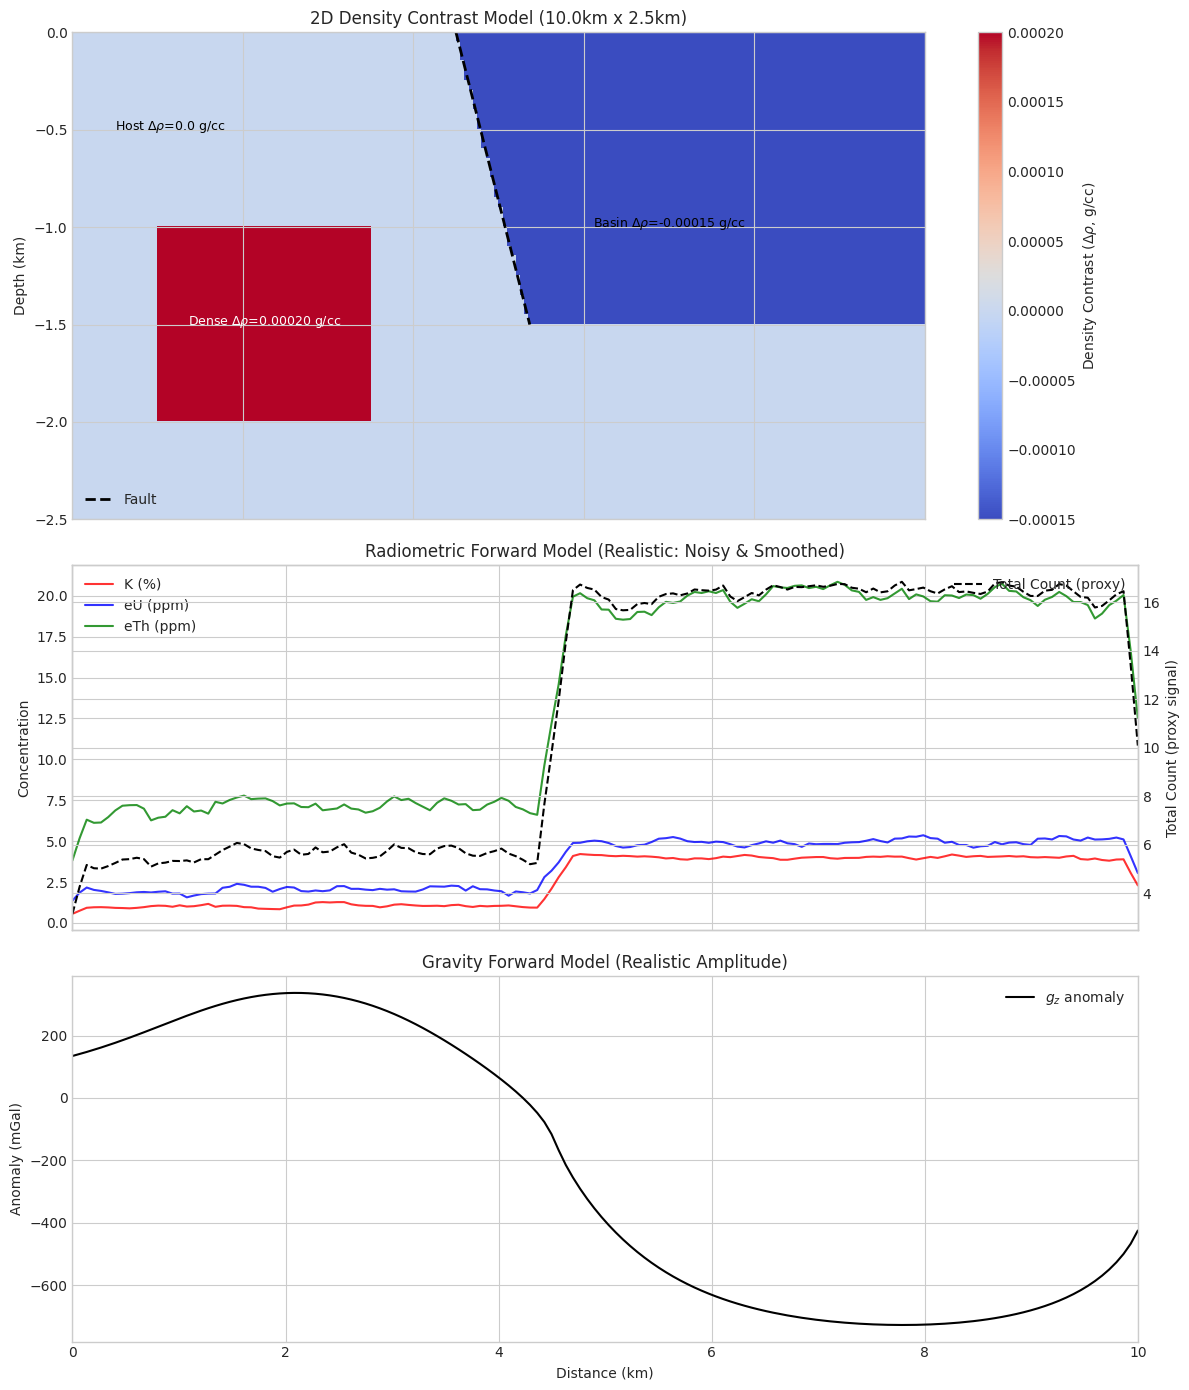

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import harmonica as hm

# -------------------------------------------------------------------
# 1. DEFINE MODEL PARAMETERS AND GEOMETRY
# -------------------------------------------------------------------

# Model dimensions
X_MIN, X_MAX = 0, 10000 # 10 km width (m)
Z_MIN, Z_MAX = -2500, 0 # 2.5 km depth (m)
Y_EXTENT = 20000 # 20km "Thickness" for 2.5D gravity

# Grid resolution
NX, NZ = 200, 50
X_COORDS = np.linspace(X_MIN, X_MAX, NX)
Z_COORDS = np.linspace(Z_MIN, Z_MAX, NZ)
XX, ZZ = np.meshgrid(X_COORDS, Z_COORDS)

# Physical Properties
# --- FINAL REALISM FIX: Drastically scale density for 2.5D model ---
# We reduce the original densities by a factor of 1000 to get
# realistic amplitudes (e.g., 200,000 mGal -> 200 mGal)
RHO_BG = 0.0
RHO_DENSE = 0.00020 # Original was 0.20 g/cc contrast
RHO_BASIN = -0.00015 # Original was -0.15 g/cc contrast

# Radiometric values are already realistic
RAD_BG = {'K': 1.0, 'U': 2.0, 'Th': 7.0}
RAD_DENSE = {'K': 0.5, 'U': 1.0, 'Th': 3.0}
RAD_BASIN = {'K': 4.0, 'U': 5.0, 'Th': 20.0}

# -------------------------------------------------------------------
# 2. CREATE THE 2D GEOLOGICAL MODEL
# -------------------------------------------------------------------
geology_model = np.ones_like(XX, dtype=int) * 1
density_model = np.full_like(XX, RHO_BG)

# Unit 2: Buried Dense Body
body_mask = (XX >= 1000) & (XX <= 3500) & (ZZ >= -2000) & (ZZ <= -1000)
geology_model[body_mask] = 2
density_model[body_mask] = RHO_DENSE

# Unit 3: Faulted Basin
fault_dip_deg = -60
fault_x_loc = 4500
fault_plane_z = (XX - fault_x_loc) * np.tan(np.deg2rad(fault_dip_deg))
basin_mask = (XX > fault_x_loc) & (ZZ > fault_plane_z) & (ZZ > -1500)
geology_model[basin_mask] = 3
density_model[basin_mask] = RHO_BASIN

print("Geological model created.")

# -------------------------------------------------------------------
# 3. DEFINE OBSERVATION POINTS (SURVEY LINE)
# -------------------------------------------------------------------
N_OBS = 150
OBS_X = np.linspace(X_MIN, X_MAX, N_OBS)
OBS_Y = np.full_like(OBS_X, 0)
OBS_Z = np.full_like(OBS_X, 5.0)
coordinates = (OBS_X, OBS_Y, OBS_Z)

# -------------------------------------------------------------------
# 4. GRAVITY FORWARD MODEL (using the grid method)
# -------------------------------------------------------------------
density_model_kg_m3 = density_model.ravel() * 1000

DX = X_COORDS[1] - X_COORDS[0]
DZ = Z_COORDS[1] - Z_COORDS[0]
X_EDGES = np.linspace(X_MIN - DX/2, X_MAX + DX/2, NX + 1)
Z_EDGES = np.linspace(Z_MIN - DZ/2, Z_MAX + DZ/2, NZ + 1)
XX_EDGES, ZZ_EDGES = np.meshgrid(X_EDGES[:-1], Z_EDGES[:-1])

west = XX_EDGES.ravel()
east = (XX_EDGES + DX).ravel()
south = np.full_like(west, -Y_EXTENT / 2)
north = np.full_like(west, Y_EXTENT / 2)
bottom = ZZ_EDGES.ravel()
top = (ZZ_EDGES + DZ).ravel()

# Stack as columns to create a (n_prisms, 6) array
prisms = np.vstack([west, east, south, north, bottom, top]).T

print("Calculating gravity anomaly...")
gravity = hm.prism_gravity(
    coordinates,
    prisms,
    density_model_kg_m3,
    field="g_z"
)

gravity_mgal = gravity * 1e5
print(f"Gravity calculation complete. Anomaly range: {gravity_mgal.min():.2f} to {gravity_mgal.max():.2f} mGal")

# -------------------------------------------------------------------
# 5. RADIOMETRIC FORWARD MODEL (Noisy & Smoothed)
# -------------------------------------------------------------------
surface_geology_ids = geology_model[-1, :]
surface_x_coords = X_COORDS

f_geology = interp1d(
    surface_x_coords,
    surface_geology_ids,
    kind='nearest',
    fill_value='extrapolate'
)
obs_geology = f_geology(OBS_X)

K_conc = np.zeros_like(OBS_X)
U_conc = np.zeros_like(OBS_X)
Th_conc = np.zeros_like(OBS_X)

mask_bg = (obs_geology == 1)
mask_dense = (obs_geology == 2)
mask_basin = (obs_geology == 3)

K_conc[mask_bg] = RAD_BG['K']
K_conc[mask_dense] = RAD_DENSE['K']
K_conc[mask_basin] = RAD_BASIN['K']
U_conc[mask_bg] = RAD_BG['U']
U_conc[mask_dense] = RAD_DENSE['U']
U_conc[mask_basin] = RAD_BASIN['U']
Th_conc[mask_bg] = RAD_BG['Th']
Th_conc[mask_dense] = RAD_DENSE['Th']
Th_conc[mask_basin] = RAD_BASIN['Th']

# Add random noise
K_noise_std = 0.2
U_noise_std = 0.4
Th_noise_std = 1.0
K_conc_noisy = K_conc + np.random.normal(0, K_noise_std, K_conc.shape)
U_conc_noisy = U_conc + np.random.normal(0, U_noise_std, U_conc.shape)
Th_conc_noisy = Th_conc + np.random.normal(0, Th_noise_std, Th_conc.shape)

# Apply smoothing filter
window_size = 5
smoothing_window = np.ones(window_size) / window_size
K_final = np.convolve(K_conc_noisy, smoothing_window, mode='same')
U_final = np.convolve(U_conc_noisy, smoothing_window, mode='same')
Th_final = np.convolve(Th_conc_noisy, smoothing_window, mode='same')

TC_signal_final = (K_final * 1.0) + (U_final * 0.5) + (Th_final * 0.5)
print("Radiometric calculation complete (with noise and smoothing).")

# -------------------------------------------------------------------
# 6. PLOT THE MODEL AND RESULTS
# -------------------------------------------------------------------
fig, axes = plt.subplots(
    3, 1,
    figsize=(12, 14),
    gridspec_kw={'height_ratios': [2, 1.5, 1.5]},
    sharex=True
)
plt.style.use('seaborn-v0_8-whitegrid')

# --- Plot 1: The Geological Model (MODIFIED TO SHOW DENSITY CONTRAST) ---
ax0 = axes[0]
im = ax0.imshow(
    density_model, # PLOT DENSITY CONTRAST
    extent=[X_MIN / 1000, X_MAX / 1000, Z_MIN / 1000, Z_MAX / 1000],
    origin='lower',
    aspect='auto',
    cmap='coolwarm', # Use a continuous, diverging colormap
    interpolation='none',
    vmin=RHO_BASIN, # Min contrast
    vmax=RHO_DENSE # Max contrast
)
# ADDED DENSITY CONTRAST COLORBAR
cbar = fig.colorbar(im, ax=ax0)
cbar.ax.set_ylabel('Density Contrast ($\Delta\\rho$, g/cc)')

ax0.set_ylabel('Depth (km)')
ax0.set_title(f'2D Density Contrast Model ({X_MAX/1000}km x {abs(Z_MIN/1000)}km)')

# Plot the fault line
fault_x_end_at_basin_bottom = fault_x_loc + (-1500 / np.tan(np.deg2rad(fault_dip_deg)))
fault_x_plot = np.linspace(fault_x_loc, fault_x_end_at_basin_bottom, 10)
fault_z_plot = (fault_x_plot - fault_x_loc) * np.tan(np.deg2rad(fault_dip_deg))
ax0.plot(fault_x_plot / 1000, fault_z_plot / 1000, 'k--', lw=2, label='Fault')

# Add annotations for density values
ax0.text(500/1000, -500/1000, f'Host $\\Delta\\rho$=0.0 g/cc', color='k', fontsize=9, ha='left')
ax0.text(2250/1000, -1500/1000, f'Dense $\\Delta\\rho$={RHO_DENSE:.5f} g/cc', color='w', fontsize=9, ha='center')
ax0.text(7000/1000, -1000/1000, f'Basin $\\Delta\\rho$={RHO_BASIN:.5f} g/cc', color='k', fontsize=9, ha='center')

ax0.set_ylim(Z_MIN / 1000, Z_MAX / 1000)
ax0.legend(loc='lower left')

# --- Plot 2: Radiometric Data (Realistic) ---
ax1 = axes[1]
ax1.plot(OBS_X / 1000, K_final, label='K (%)', color='red', alpha=0.8)
ax1.plot(OBS_X / 1000, U_final, label='eU (ppm)', color='blue', alpha=0.8)
ax1.plot(OBS_X / 1000, Th_final, label='eTh (ppm)', color='green', alpha=0.8)
ax1.set_ylabel('Concentration')
ax1.set_title('Radiometric Forward Model (Realistic: Noisy & Smoothed)')
ax1.legend()
ax1b = ax1.twinx()
ax1b.plot(OBS_X / 1000, TC_signal_final, 'k--', label='Total Count (proxy)')
ax1b.set_ylabel('Total Count (proxy signal)')
ax1b.legend(loc='upper right')

# --- Plot 3: Gravity Data (Realistic 2D Model) ---
ax2 = axes[2]
ax2.plot(OBS_X / 1000, gravity_mgal, 'k-', label='$g_z$ anomaly')
ax2.set_ylabel('Anomaly (mGal)')
ax2.set_title('Gravity Forward Model (Realistic Amplitude)')
ax2.legend()
ax2.set_xlabel('Distance (km)')

plt.tight_layout()
plt.show()